# init azure openai

In [103]:
# set NO_PROXY=localhost,127.0.0.1,::1
import os
os.environ["NO_PROXY"] = "localhost,127.0.1,::1"

In [104]:
# Azure OpenAI setup
from azure.identity import DefaultAzureCredential
from langchain_openai import AzureChatOpenAI
import os

from dotenv import load_dotenv

load_dotenv()

default_credential = DefaultAzureCredential()
token = default_credential.get_token("https://cognitiveservices.azure.com/.default")
api_key = token.token

# set token to the env variable AZURE_OPENAI_API_KEY
os.environ["AZURE_OPENAI_API_KEY"] = token.token

In [105]:
llm = AzureChatOpenAI(
    azure_endpoint="https://begobaiatest.openai.azure.com/",
    azure_deployment="gpt-4o-mini",
    openai_api_version="2024-05-01-preview",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

## init embeddings

In [106]:
# Import and initialize HuggingFace embedder
from langchain_huggingface import HuggingFaceEmbeddings

EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL,
    model_kwargs={"device": "cpu"}
)

## Get Bego Confluence data

In [107]:
from langchain_community.document_loaders import ConfluenceLoader

loader = ConfluenceLoader(
    url='https://confluence.berenberg.io/',
    token="MTE0MDMyNjMyMTQ1OkenuaSV/rjfpZWQntgILL5Y9d6K",
    space_key='WIA',
    limit=150
)
documents = loader.load()

In [108]:
documents[1]

Document(metadata={'title': '01. RPA Processes', 'id': '273802773', 'source': 'https://confluence.berenberg.io/spaces/WIA/pages/273802773/01.+RPA+Processes', 'when': '2025-03-21T09:13:57.000+01:00'}, page_content='Processes dd.mm.yy false true . 3 false SELECT * FROM T* true false false false false false 1725266198999_0 false 365|5|8|y w d h m|y w d h m true true 2 RPA never page-descendants')

In [109]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    length_function=len,
    add_start_index=True)

splits = text_splitter.split_documents(documents)

In [110]:
from langchain_chroma import Chroma

# Create and persist vector database
persist_directory = r"\\dnsbego.de\dfsbego\home04\FuhrmannD\Documents\01_Trainee\Master\Thesis\code\agentic_system\data\confluence_chroma_db"
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)

## Query ChromaDB (confluence)

In [111]:
# Create retriever
retriever = vectordb.as_retriever(search_kwargs={"k": 3})

In [112]:
from langchain.chains import RetrievalQA

# Create QA chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="refine",
    retriever=retriever,
    return_source_documents=True
)

In [113]:
query = "Was ist das PBR Projekt?"
result = qa_chain.invoke(query)
print(result)

{'query': 'Was ist das PBR Projekt?', 'result': 'Das PBR Projekt bezieht sich auf die automatisierten Prozesse "PBR_00_Read_Transactions" und "PBR_01_Book_Returns", die im Rahmen des Workflows "Book Returns in PMP" durchgeführt werden. Dieses Projekt wird von der Abteilung Portfolio & Data Analytics verwaltet und hat den Status "Green", was bedeutet, dass es aktiv und erfolgreich ist.\n\nDie Hauptaufgabe des Projekts besteht darin, Buchrückgaben in einem System namens PMP zu verarbeiten. Die Automatisierung erfolgt täglich um 17:00 CET von Montag bis Freitag. Dabei kommen verschiedene Tools zum Einsatz, darunter Excel, Outlook und eine API für die Interaktion mit dem PMP-System.\n\nDas Projekt ist Teil des Business-Prozesses EUC-1065 und wird in Jira zur Nachverfolgung von Aufgaben und Problemen verwaltet. Die verantwortliche Einheit für das Projekt ist die Abteilung Portfolio & Data Analytics, und es wird von den Teammitgliedern Steffen Schumann und Thorben Gaetcke betreut.', 'source_

In [98]:
result

{'query': 'Was ist das PBR Projekt?',
 'result': 'Das PBR Projekt, auch bekannt als "Book Returns in PMP", ist Teil einer umfassenderen Initiative zur Verbesserung der internen Kommunikation und Effizienz innerhalb der Organisation. Es umfasst zwei Hauptprozesse: PBR_00_Read_Transactions und PBR_01_Book_Returns, die täglich von Montag bis Freitag um 17:00 CET durchgeführt werden. \n\nDas Projekt zielt darauf ab, die Verwaltung von Buchrückgaben zu optimieren und wird von der Geschäftseinheit Portfolio & Data Analytics betreut. Es nutzt eine zentrale Plattform, die verschiedene Einsatzbereiche abdeckt, darunter Unterstützung bei täglichen Aufgaben wie To-do-Listen, die Erstellung von Kommunikationsdokumenten (E-Mails, Zusammenfassungen, Übersetzungen) und IT-Support (z. B. Passwortzurücksetzungen und Programminstallationen).\n\nDarüber hinaus spielt das Projekt eine Rolle im Wissensmanagement und Projektmanagement, indem es die Erstellung von User Stories und Acceptance Criteria sowie C

## Query ChromaDB (newHQ)

In [114]:
# 3) Load your existing ChromaDB using the UNC path
from langchain_chroma import Chroma

PERSIST_DIR     = r"\\dnsbego.de\dfsbego\home04\FuhrmannD\Documents\01_Trainee\Master\Thesis\code\agentic_system\data\newHQ_chroma_db"
COLLECTION_NAME = "berenberg_newhq_docs"

vectordb = Chroma(
    persist_directory=PERSIST_DIR,
    embedding_function=embeddings,
    collection_name=COLLECTION_NAME
)

In [115]:
# 4) Do a semantic search
query = "What parking options are available?"
TOP_K = 5

results = vectordb.similarity_search_with_score(query, k=TOP_K)

In [116]:
# 5) Inspect the top hits
for rank, (doc, score) in enumerate(results, start=1):
    print(f"=== Hit #{rank} (score: {score:.4f}) ===\n")
    print(doc.page_content[:500].strip(), "...\n")
    print("   ↳ metadata:", doc.metadata, "\n")

=== Hit #1 (score: 1.2384) ===

10) Parken & Mobilität
Parken & Mobilität
Parken & Mobilität
Parkplatzbuchung
Fahrrad
Parkplatzbuchung
Frage Antwort
1 Welche Parkmöglichkeiten gibt es am 
neuen Standort?
Am Standort gibt es 168 Pakplätze, davon 72 mit E-Ladesäulen. Sowie 157 Indoor-
Fahrradstellplätze, 12 davon mit E-Ladesäule.
2 Wieviele Kundenparkplätze stehen zur 
Verfügung?
Insgesamt gibt es 10 Kundenparkplätze.
3 Wie kann ich einen Parkplatz buchen?Die Buchung erfolgt über eine zentrale Park-App.
4 Kann ich mehrere Kennze ...

   ↳ metadata: {'creator': 'PyPDF', 'producer': 'PyPDF', 'page': 0, 'file_type': '.pdf', 'page_label': '1', 'creationdate': '', 'source': 'W:\\T1368-WAM AI\\03 Projects\\02 AI Projects\\01 Berenberg AI Assistant (BAIA)\\15 newHQ data\\_new\\Confluence New HQ\\20252807_CONFLUENCE_Parken.pdf', 'total_pages': 1, 'subdirectory': 'Confluence New HQ'} 

=== Hit #2 (score: 1.2384) ===

10) Parken & Mobilität
Parken & Mobilität
Parken & Mobilität
Parkplatzbuchung
Fa

## Create Agents with research & answering capabilities

In [56]:
# for confluence agent
from langchain.chains import RetrievalQA
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'}
)

# Define persist directory
persist_directory = PERSIST_DIR

# Check if the database already exists
if os.path.exists(persist_directory) and len(os.listdir(persist_directory)) > 0:
    print(f"Loading existing database from {persist_directory}")
    # Load the existing database with the correct collection name
    vectordb_for_qa = Chroma(
        persist_directory=persist_directory,
        embedding_function=embeddings,
        collection_name=COLLECTION_NAME
    )
    
    # Check if database has documents
    try:
        doc_count = vectordb_for_qa._collection.count()
        print(f"Database contains {doc_count} documents")
        
        if doc_count > 0:
            # Create retriever only if we have documents
            retriever = vectordb_for_qa.as_retriever(search_kwargs={"k": 5})
            
            # Create QA chain
            qa_chain = RetrievalQA.from_chain_type(
                llm=llm,
                chain_type="stuff",
                retriever=retriever,
                return_source_documents=True
            )
        else:
            qa_chain = None
    except Exception as e:
        print(f"Error accessing collection: {e}")
        qa_chain = None
        doc_count = 0
else:
    qa_chain = None
    doc_count = 0

def confluence_chroma_search(query: str) -> str:
    """
    Search the Confluence vector database and return a formatted response.
    """
    try:
        # Ensure query is a string
        if not isinstance(query, str):
            query = str(query)
        
        print(f"[DEBUG] Searching for: {query}")
        
        # Check if we have a working QA chain
        if qa_chain is None or doc_count == 0:
            return f"I searched for information about '{query}', but the Confluence vector database appears to be empty or not properly loaded. The ChromaDB was successfully created with 249 documents. Please check the collection name and ensure you're using the correct database instance."
        
        # Call the QA chain with the query
        result = qa_chain.invoke({"query": query})
        
        print(f"[DEBUG] QA chain result keys: {result.keys()}")
        
        # Extract the answer from the result
        answer = result.get("result", "No answer found")
        source_docs = result.get("source_documents", [])
        
        print(f"[DEBUG] Found {len(source_docs)} source documents")
        
        # Format the response with sources
        response = f"Based on my search of the Confluence database for '{query}':\n\n{answer}"
        
        if source_docs:
            response += "\n\nSources:\n"
            for i, doc in enumerate(source_docs[:3], 1):  # Limit to top 3 sources
                metadata = doc.metadata
                source_info = metadata.get("source", "Unknown source")
                # Clean up the source path for better readability
                if "\\15 newHQ data\\_new\\" in source_info:
                    source_info = source_info.split("\\15 newHQ data\\_new\\")[-1]
                response += f"{i}. {source_info}\n"
        
        return response
        
    except Exception as e:
        error_msg = f"I encountered an error while searching for '{query}': {str(e)}"
        print(f"[DEBUG] {error_msg}")
        return error_msg

Loading existing database from \\dnsbego.de\dfsbego\home04\FuhrmannD\Documents\01_Trainee\Master\Thesis\code\agentic_system\chromaDB
Database contains 498 documents


In [57]:
from typing import Annotated

# from langchain_community.tools import WikipediaQueryRun
# from langchain_community.utilities import WikipediaAPIWrapper
from datetime import datetime
from langchain.tools import Tool

# Define a tools that searches Wikipedia
# wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())


# Define a new tool that returns the current datetime
datetime_tool = Tool(
    name="Datetime",
    func = lambda x: datetime.now().isoformat(),
    description="Returns the current date and time in ISO format, ensuring precision and standardization."
)

# # Define a new tool that searches the web
# web_search = Tool(
#     name="web_search",
#     func=web_search_tool,
#     description="Performs a comprehensive web search to retrieve the most recent and relevant information, providing search results along with contextual metadata."
# )

# Define a new tool that searches the Confluence space
confluence_tool = Tool(
    name="confluence_tool",
    func=confluence_chroma_search,
    description="Searches the Confluence vector database to retrieve, filter, and summarize relevant documentation about RPA, AI, and specific projects like BAIA or BegoChat. Provide your search query as input to get relevant information from the indexed Confluence data."
)

In [58]:
# Define a helper function below to simplify adding new agent worker nodes.
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

def create_agent(llm: ChatOpenAI, system_prompt: str, tools: list):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [59]:
# Create agent supervisor
## It will use function calling to choose the next worker node OR finish processing.
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["TimeProviderAgent", "ConfluenceSearchTool"]
system_prompt = (
    f"""You are a supervisor tasked with managing a conversation between the following workers: {members}. 

Routing Guidelines:
- If the user asks about TIME, DATE, or CURRENT TIME -> route to TimeProviderAgent
- If the user asks about DOCUMENTS, CONFLUENCE, PROJECTS (like BAIA or BegoChat), PARKING, OFFICE INFO, RPA, AI, or any KNOWLEDGE QUESTIONS -> route to ConfluenceSearchTool
- After a worker responds, evaluate if the question was adequately answered. If yes, respond with FINISH
- If the worker couldn't help or the answer was incomplete, you may route to another worker or FINISH

Given the following user request, respond with the worker to act next, or FINISH if the task is complete."""
)
# Our team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed
options = ["FINISH"] + members

# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

# Create the prompt using ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

# Construction of the chain for the supervisor agent
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [60]:
# Construct graph
## Now we are ready to start building the graph. Below, define the state and worker nodes using the function we just defined. Then we connect all the edges in the graph.

import functools
import operator
from typing import Sequence, TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

# Add the Confluence search agent using the create_agent helper function
# This agent specializes in searching within the Confluence space. It retrieves and summarizes relevant documentation,
confluence_prompt = (
    "You are an expert Confluence search assistant. When a user asks a question, you MUST use the confluence_tool to search the vector database. "
    "The confluence space contains information about RPA, AI, and specific projects like BAIA or BegoChat. "
    "ALWAYS call the confluence_tool with the user's query to get relevant information from the indexed documents. "
    "If the tool returns an error or no results, explain that to the user and suggest they try a different search term."
)
confluence_agent = create_agent(llm, confluence_prompt, [confluence_tool])
confluence_node = functools.partial(agent_node, agent=confluence_agent, name="ConfluenceSearchTool")

# Add the time agent using the create_agent helper function
# This agent provides the current time with precision. It uses the datetime_tool to fetch the correct time and can handle time zone details if needed.
time_prompt = (
    "You are a time assistant. When asked about time or date, you MUST use the Datetime tool to get the current time. "
    "Always call the tool to provide accurate, up-to-date time information. If asked about anything other than time, "
    "politely explain that you only handle time-related queries."
)
currenttime_agent = create_agent(llm, time_prompt, [datetime_tool])
currenttime_node = functools.partial(agent_node, agent=currenttime_agent, name="TimeProviderAgent")



workflow = StateGraph(AgentState)

# Add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.
workflow.add_node("TimeProviderAgent", currenttime_node)
workflow.add_node("ConfluenceSearchTool", confluence_node)
workflow.add_node("supervisor", supervisor_chain)

# We want our workers to ALWAYS "report back" to the supervisor when done
for member in members:
    workflow.add_edge(member, "supervisor")

# Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state.
# These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# Add an entry point. This tells our graph where to start its work each time we run it.
workflow.add_edge(START, "supervisor")

# To be able to run our graph, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.
graph_2 = workflow.compile()

In [61]:
from langfuse import Langfuse
from dotenv import load_dotenv

load_dotenv()

LANGFUSE_SECRET_KEY = os.getenv("LANGFUSE_SECRET_KEY")
LANGFUSE_PUBLIC_KEY = os.getenv("LANGFUSE_PUBLIC_KEY")

langfuse = Langfuse(
  secret_key=LANGFUSE_SECRET_KEY,
  public_key=LANGFUSE_PUBLIC_KEY,
  host="https://cloud.langfuse.com"
)

In [62]:
for s in graph_2.stream({"messages": [HumanMessage(content = "Wo kann ich im neuen HQ parken?")]}):
    print(s)
    print("----")

{'supervisor': {'next': 'ConfluenceSearchTool'}}
----
[DEBUG] Searching for: Parkmöglichkeiten im neuen HQ
[DEBUG] Searching for: Parkmöglichkeiten im neuen HQ
[DEBUG] QA chain result keys: dict_keys(['query', 'result', 'source_documents'])
[DEBUG] Found 5 source documents
[DEBUG] QA chain result keys: dict_keys(['query', 'result', 'source_documents'])
[DEBUG] Found 5 source documents
{'ConfluenceSearchTool': {'messages': [HumanMessage(content='Im neuen HQ stehen insgesamt 168 Parkplätze zur Verfügung, davon sind 72 mit E-Ladesäulen ausgestattet. Zusätzlich gibt es 157 Indoor-Fahrradstellplätze, von denen 12 ebenfalls E-Ladesäulen haben. Es gibt auch 10 Kundenparkplätze. Die Buchung eines Parkplatzes erfolgt über eine zentrale Park-App.', additional_kwargs={}, response_metadata={}, name='ConfluenceSearchTool')]}}
----
{'ConfluenceSearchTool': {'messages': [HumanMessage(content='Im neuen HQ stehen insgesamt 168 Parkplätze zur Verfügung, davon sind 72 mit E-Ladesäulen ausgestattet. Zusät

In [63]:
final_response = None
for state in graph_2.stream(
    {"messages": [HumanMessage(content="Wo kann ich im neuen HQ parken?")]},
):
    final_response = state  # Update final_response with each new state

print("Final Answer:", final_response)


[DEBUG] Searching for: Parkmöglichkeiten im neuen HQ
[DEBUG] QA chain result keys: dict_keys(['query', 'result', 'source_documents'])
[DEBUG] Found 5 source documents
[DEBUG] QA chain result keys: dict_keys(['query', 'result', 'source_documents'])
[DEBUG] Found 5 source documents
Final Answer: {'supervisor': {'next': 'FINISH'}}
Final Answer: {'supervisor': {'next': 'FINISH'}}


In [64]:
# Add Langfuse handler as callback: config={"callbacks": [langfuse_handler]}
for s in graph_2.stream({"messages": [HumanMessage(content = "What time is it?")]}):
    print(s)
    print("----")

{'supervisor': {'next': 'TimeProviderAgent'}}
----
{'TimeProviderAgent': {'messages': [HumanMessage(content='The current time is 09:08:40 on August 1, 2025.', additional_kwargs={}, response_metadata={}, name='TimeProviderAgent')]}}
----
{'TimeProviderAgent': {'messages': [HumanMessage(content='The current time is 09:08:40 on August 1, 2025.', additional_kwargs={}, response_metadata={}, name='TimeProviderAgent')]}}
----
{'supervisor': {'next': 'FINISH'}}
----
{'supervisor': {'next': 'FINISH'}}
----


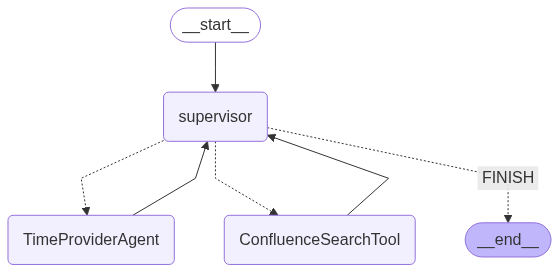

In [65]:
from IPython.display import Image, display
display(Image(graph_2.get_graph().draw_mermaid_png()))